In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
import cv2
import glob
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data pre-processing

In [15]:
dim = 180
def findeyestate(eyestate, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Train', 'Test']
    if not k_fold:
        path = "drive/MyDrive/input/" + data_type + "/"
        for i,f in enumerate(eyestate):
            p = path + f
            j=0
            for image_path in glob.glob(p+"/*"):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , eyestate[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "/content/drive/MyDrive/input/" + v + "/"
            for i,f in enumerate(eyestate):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [16]:
eyestate = ['Closed_Eyes' , 'Open_Eyes'] #Binary classification
X_t, y_train =  findeyestate(eyestate, 'Train', print_n=True, k_fold=False)
X_test, y_test = findeyestate(eyestate, 'Test', print_n=True, k_fold=False)
X,y = findeyestate(eyestate, '', print_n=True, k_fold=True)
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

There are  2000   TRAIN  images of  CLOSED_EYES
There are  2000   TRAIN  images of  OPEN_EYES
There are  736   TEST  images of  CLOSED_EYES
There are  726   TEST  images of  OPEN_EYES


## SVM

Accuracy with SVM: 80.57%


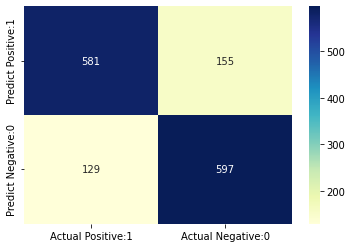

In [17]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train) 
y_pred = svm.predict(X_test)

precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

cm  = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

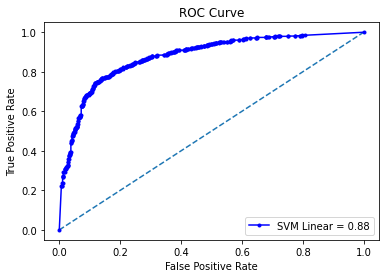

In [18]:
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM Linear = %0.2f' % svm_auc )
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy with SVM: 76.06%


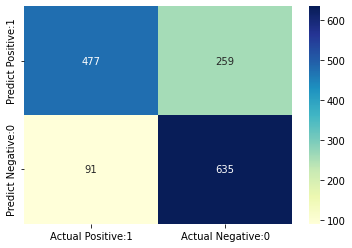

In [19]:
svm = SVC(gamma='auto', kernel='rbf', probability=True)
svm.fit(X_train, y_train) 
y_pred = svm.predict(X_test)

precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

cm  = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

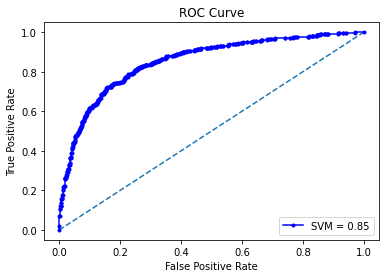

In [20]:
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.2f' % svm_auc )
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

Accuracy with Random Forest Classifier : 76.74%


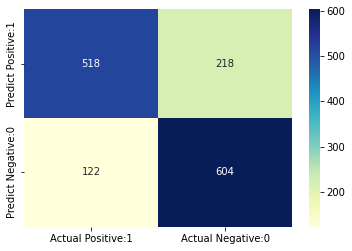

In [21]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forest Classifier : {0:.2f}%".format(precision))
cm  = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
# calculate the FPR and TPR for all thresholds of the classification
probs = rfc.predict_proba(X_test)
probs = probs[:, 1]
rfc_fpr, rfc_tpr, thresholds = metrics.roc_curve(y_test, probs)
rfc_auc = metrics.roc_auc_score(y_test, probs)

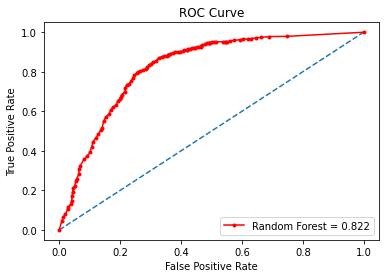

In [22]:
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(rfc_fpr, rfc_tpr, 'r', marker='.', label = 'Random Forest = %0.3f' % rfc_auc )
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()